In [21]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [22]:
df = pd.read_csv('NFLX.csv')
df
df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
df.head()

,date,open,high,low,close,adj_close,volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [23]:
print("Total number of days: ",df.shape[0])
print("Total number of features: ",df.shape[1])

Total number of days:  1009
Total number of features:  7


In [24]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [25]:
df_close = df[['date','close']]

df_close_original = df_close.copy()

print("Shape of close dataframe:", df_close.shape)
df_close

Shape of close dataframe: (1009, 2)


,date,close
0,2018-02-05 00:00:00+00:00,254.259995
1,2018-02-06 00:00:00+00:00,265.720001
2,2018-02-07 00:00:00+00:00,264.559998
3,2018-02-08 00:00:00+00:00,250.100006
4,2018-02-09 00:00:00+00:00,249.470001
...,...,...
1004,2022-01-31 00:00:00+00:00,427.140015
1005,2022-02-01 00:00:00+00:00,457.130005
1006,2022-02-02 00:00:00+00:00,429.480011
1007,2022-02-03 00:00:00+00:00,405.600006


In [26]:
training_size=int(len(df_close)*0.80)

test_size=len(df_close)-training_size

train_data,test_data = df_close[0:training_size],df_close[training_size:len(df_close)]

print("train_data: ", train_data.shape)

print("test_data: ", test_data.shape)

train_data

train_data:  (807, 2)
test_data:  (202, 2)


,date,close
0,2018-02-05 00:00:00+00:00,254.259995
1,2018-02-06 00:00:00+00:00,265.720001
2,2018-02-07 00:00:00+00:00,264.559998
3,2018-02-08 00:00:00+00:00,250.100006
4,2018-02-09 00:00:00+00:00,249.470001
...,...,...
802,2021-04-14 00:00:00+00:00,540.020020
803,2021-04-15 00:00:00+00:00,549.219971
804,2021-04-16 00:00:00+00:00,546.539978
805,2021-04-19 00:00:00+00:00,554.440002


In [27]:
del train_data['date']
del test_data['date']

In [28]:
scaler=MinMaxScaler(feature_range=(0,1))

train_data=scaler.fit_transform(np.array(train_data).reshape(-1,1))

test_data = scaler.transform(np.array(test_data).reshape(-1,1))

print(df_close.shape)

print(train_data[:])

time_step = 150

(1009, 2)
[[0.05782213]
 [0.09033648]
 [0.08704531]
 [0.04601941]
 [0.04423196]
 [0.06829145]
 [0.06919929]
 [0.09113089]
 [0.13161772]
 [0.12665262]
 [0.12673773]
 [0.13380242]
 [0.12557455]
 [0.14767629]
 [0.17102649]
 [0.16095437]
 [0.16313907]
 [0.16033027]
 [0.19057476]
 [0.23015375]
 [0.25914995]
 [0.24763092]
 [0.23582815]
 [0.27679734]
 [0.24802808]
 [0.2326505 ]
 [0.24873738]
 [0.24743229]
 [0.23994213]
 [0.22584123]
 [0.23724675]
 [0.23435284]
 [0.20660501]
 [0.1902627 ]
 [0.24533279]
 [0.1895534 ]
 [0.14722233]
 [0.17440276]
 [0.13167452]
 [0.14126427]
 [0.15621629]
 [0.17048741]
 [0.15596095]
 [0.15902509]
 [0.18211995]
 [0.19800829]
 [0.21383984]
 [0.22064911]
 [0.20966915]
 [0.2899052 ]
 [0.28553588]
 [0.28037224]
 [0.26638478]
 [0.24062303]
 [0.20751285]
 [0.20393804]
 [0.22725983]
 [0.22096124]
 [0.22294723]
 [0.22533047]
 [0.2255007 ]
 [0.22076262]
 [0.24459509]
 [0.26210066]
 [0.26388811]
 [0.27356289]
 [0.2715769 ]
 [0.26266805]
 [0.26854108]
 [0.26173181]
 [0.267576

In [29]:
with open('output.txt', 'w') as file:
    # Iterate over the list and write each element to the file
    for item in train_data:
        file.write("%s\n" % item)

next_30_values = [
    [0.87641109],
    [0.88431021],
    [0.89645411],
    [0.88547964],
    [0.89205694],
    [0.89967637],
    [0.90439661],
    [0.92138164],
    [0.91506684],
    [0.91824554],
    [0.90212755],
    [0.89536545],
    [0.90215595],
    [0.90803048],
    [0.91976718],
    [0.93034311],
    [0.93811154],
    [0.93952228],
    [0.95305247],
    [0.96535431],
    [0.96139918],
    [0.96867179],
    [0.96549714],
    [0.95663311],
    [0.95023291],
    [0.94985519],
    [0.95859197],
    [0.95576525],
    [0.96265688]
]

In [30]:
def create_sliding_window(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [31]:

X_train, y_train = create_sliding_window(train_data, time_step)
X_test, y_test = create_sliding_window(test_data, time_step)


print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

for i in range(15):
    print(X_train[i][:5])

X_train:  (656, 150)
y_train:  (656,)
X_test:  (51, 150)
y_test (51,)
[0.05782213 0.09033648 0.08704531 0.04601941 0.04423196]
[0.09033648 0.08704531 0.04601941 0.04423196 0.06829145]
[0.08704531 0.04601941 0.04423196 0.06829145 0.06919929]
[0.04601941 0.04423196 0.06829145 0.06919929 0.09113089]
[0.04423196 0.06829145 0.06919929 0.09113089 0.13161772]
[0.06829145 0.06919929 0.09113089 0.13161772 0.12665262]
[0.06919929 0.09113089 0.13161772 0.12665262 0.12673773]
[0.09113089 0.13161772 0.12665262 0.12673773 0.13380242]
[0.13161772 0.12665262 0.12673773 0.13380242 0.12557455]
[0.12665262 0.12673773 0.13380242 0.12557455 0.14767629]
[0.12673773 0.13380242 0.12557455 0.14767629 0.17102649]
[0.13380242 0.12557455 0.14767629 0.17102649 0.16095437]
[0.12557455 0.14767629 0.17102649 0.16095437 0.16313907]
[0.14767629 0.17102649 0.16095437 0.16313907 0.16033027]
[0.17102649 0.16095437 0.16313907 0.16033027 0.19057476]


In [32]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print(X_test[0])

X_train:  (656, 150, 1)
X_test:  (51, 150, 1)
[[0.78028704]
 [0.77994659]
 [0.7707824 ]
 [0.78425911]
 [0.7707824 ]
 [0.77353449]
 [0.78057078]
 [0.79325299]
 [0.78088283]
 [0.76405825]
 [0.74391411]
 [0.7537592 ]
 [0.76593081]
 [0.71727283]
 [0.7410769 ]
 [0.71242124]
 [0.71718772]
 [0.73622531]
 [0.72365653]
 [0.71610957]
 [0.72013843]
 [0.75977413]
 [0.74904952]
 [0.76326384]
 [0.75883781]
 [0.76173172]
 [0.76598753]
 [0.7630085 ]
 [0.75242571]
 [0.75287967]
 [0.72504673]
 [0.74011226]
 [0.73988533]
 [0.73344491]
 [0.71477608]
 [0.71891837]
 [0.72317417]
 [0.75472392]
 [0.73205462]
 [0.73350163]
 [0.75032621]
 [0.75722058]
 [0.74652437]
 [0.78006011]
 [0.79118189]
 [0.80627582]
 [0.83183903]
 [0.84874881]
 [0.85008221]
 [0.83507348]
 [0.85019564]
 [0.85144401]
 [0.87317707]
 [0.85706179]
 [0.84230831]
 [0.85711841]
 [0.86089194]
 [0.8704533 ]
 [0.8910798 ]
 [0.8768938 ]
 [0.84103153]
 [0.84662091]
 [0.84313103]
 [0.79370704]
 [0.7884298 ]
 [0.79875717]
 [0.80182139]
 [0.80868737]
 [

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [34]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000020D0FECF910>>

In [35]:
epochs= 50
batch_size = 16
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1)

Epoch 1/50


41/41 [==============================] - 2s 28ms/step - loss: 0.0397
Epoch 2/50
41/41 [==============================] - 1s 29ms/step - loss: 0.0030
Epoch 3/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0025
Epoch 4/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0024
Epoch 5/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0027
Epoch 6/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0024
Epoch 7/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0024
Epoch 8/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0022
Epoch 9/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0020
Epoch 10/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0021
Epoch 11/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0020
Epoch 12/50
41/41 [==============================] - 1s 28ms/step - loss: 0.0019
Epoch 13/50
41/41 [=============================

In [36]:
predictions = []

last_prices = X_train

for i in range(60):
    temp_matrix = np.zeros((time_step,1))

    for i in range(time_step-1):
        temp_matrix[i][0] = last_prices[-1][i+1]
    

    
    prediction= model.predict(last_prices[-time_step:]).flatten()[-1]
    temp_matrix[0,-1] = prediction

    predictions.append(prediction)
    last_prices = last_prices + temp_matrix
    
print(predictions)




5/5 [==============================] - 0s 13ms/step
[0.86864835, 1.0909717, 0.9698065, 0.42383873, 1.3574197, 8.246913, 9.7631235, 37.985703, 62.66672, 24.935213, 265.14038, 1710.1694, -2045.4901, 866.28503, 360.84262, 3307.646, 3506.2734, 7625.0127, 34768.67, 5005.1025, 9610.748, 36026.176, 103432.055, -56096.426, 348488.6, 314681.66, 1868048.5, 2091496.5, 265039.16, 1120009.8, 5064698.0, 66766524.0, -1660767.5, 438508400.0, 189360140.0, 73902860.0, -84868460.0, 1414719200.0, 1780785700.0, 5948450300.0, 485302460.0, 59173523000.0, 12899459000.0, 117850520000.0, 56431850000.0, 2024838400000.0, 3859646000000.0, 4906471700000.0, 12890640000000.0, 520829930000.0, 1420886900000.0, 218455160000000.0, 69049090000000.0, 598249700000000.0, 926042300000000.0, 12212098000000.0, 72856530000000.0, 944911060000000.0, 2.3257476e+16, 188106950000000.0]


In [37]:
predictions_array = np.array(predictions)
predictions_reshaped = predictions_array.reshape(-1,1)
predicted_prices = scaler.inverse_transform(predictions_reshaped)
predicted_prices

array([[ 5.40043823e+02],
       [ 6.18403931e+02],
       [ 5.75697998e+02],
       [ 3.83266235e+02],
       [ 7.12316223e+02],
       [ 3.14058716e+03],
       [ 3.67499072e+03],
       [ 1.36223213e+04],
       [ 2.23213926e+04],
       [ 9.02254590e+03],
       [ 9.36852656e+04],
       [ 6.03000250e+05],
       [-7.20719625e+05],
       [ 3.05564719e+05],
       [ 1.27416484e+05],
       [ 1.16604688e+06],
       [ 1.23605512e+06],
       [ 2.68774600e+06],
       [ 1.22548010e+07],
       [ 1.76433238e+06],
       [ 3.38763825e+06],
       [ 1.26980210e+07],
       [ 3.64559000e+07],
       [-1.97715140e+07],
       [ 1.22828528e+08],
       [ 1.10912936e+08],
       [ 6.58412608e+08],
       [ 7.37169152e+08],
       [ 9.34159360e+07],
       [ 3.94758880e+08],
       [ 1.78510374e+09],
       [ 2.35325297e+10],
       [-5.85353920e+08],
       [ 1.54556678e+11],
       [ 6.67418788e+10],
       [ 2.60478054e+10],
       [-2.99127398e+10],
       [ 4.98631967e+11],
       [ 6.2

In [38]:
test_prices = scaler.inverse_transform(test_data)
train_prices = scaler.inverse_transform(train_data)
next_30_values = scaler.inverse_transform(next_30_values)
test_prices

array([[508.899994],
       [508.779999],
       [505.549988],
       [510.299988],
       [505.549988],
       [506.519989],
       [509.      ],
       [513.469971],
       [509.109985],
       [503.179993],
       [496.079987],
       [499.549988],
       [503.839996],
       [486.690002],
       [495.079987],
       [484.980011],
       [486.660004],
       [493.369995],
       [488.940002],
       [486.279999],
       [487.700012],
       [501.670013],
       [497.890015],
       [502.899994],
       [501.339996],
       [502.359985],
       [503.859985],
       [502.809998],
       [499.079987],
       [499.23999 ],
       [489.429993],
       [494.73999 ],
       [494.660004],
       [492.390015],
       [485.809998],
       [487.269989],
       [488.769989],
       [499.890015],
       [491.899994],
       [492.410004],
       [498.339996],
       [500.769989],
       [497.      ],
       [508.820007],
       [512.73999 ],
       [518.059998],
       [527.070007],
       [533.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


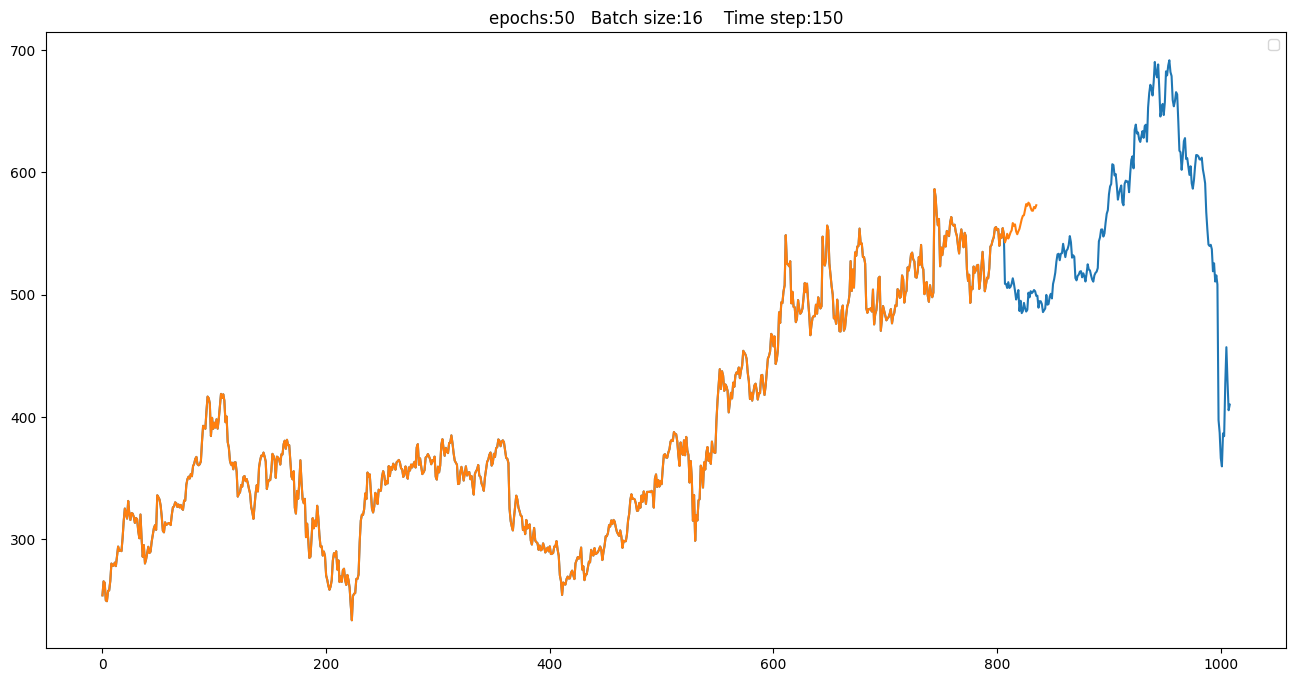

In [39]:
import matplotlib.pyplot as plt

# plt.plot(train_prices+predicted_prices)
# plt.plot(train_prices+test_prices)
plt.figure(figsize = (16,8))
# plt.plot(np.vstack((train_prices,predicted_prices)))
plt.plot(np.vstack((train_prices,test_prices)))
plt.plot(np.vstack((train_prices,next_30_values)))
title = "epochs:"+ str(epochs)+"   Batch size:"+str(batch_size)+"    Time step:"+str(time_step)
plt.title(title)
plt.legend()
plt.show()